In [51]:
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import time

# Zadanie 2
## Damian Baraniak 324851
#### WSI-24L-G104
Celem zadania jest implementacja algorymtu ewolucyjnego oraz weryfikacja jego działania na przykładzie minimalizacji dwóch funckcji dwuwymiarowych.
- Funkcja Himmelblau:
    $$ f(x,y)=(x^2+y-11)^2+(x+y^2-7)^2 $$ 
- Funckcja Ackleya w wersji dwuwymiarowej:
    $$ f(x,y) = -20\exp(-0.2\sqrt{0.5(x^2+y^2)})-\exp(0.5(\cos2\pi x+\cos2\pi y))+20+e $$

In [52]:
def himmelblau_function(x:float,y:float)->float:
    elem1 = (x**2 + y - 11)**2 
    elem2 = (x + y**2 - 7)**2
    return elem1+elem2

def ackley_function(x:float,y:float)->float:
    elem1 = np.exp(-0.2*np.sqrt(0.5*(x**2+y**2)))
    elem2 = np.exp(0.5*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y)))
    return -20*elem1-elem2+20+np.e

## Struktura algorytmu
Algorytm do poprawnego działania potrzebuje szeregu parametrów. Są to:
- funckcja oceny - funkcja oceniająca osobniki, który najlepiej spełnia wymagania, w naszym przypadku jest to minimalizowanie podanych funkcji
- populacja początkowa - określona grupa osobników początkowych, wygenerowana losowo w pewnym obszarze
- prawdopodobnieństwo krzyżowania - określa jak często będzie dochodzić do krzyżowania między osobnikami
- siła mutacji - określa jak bardzo cechy osobnika mogą się zmieniać w wyniku mutacji
- liczba iteracji - ile razy należy powtórzyć proces ewolucji

### Osobnik 
Do działania algorytmu potrzebny jest osobnik, który będzie podlegać ocenie, mutacji i krzyżowaniu w przypadku tego zadania będzie to dwuwymiarowy wektor $[x,y]$

### Proces
Cały proces zaczyna się od wylosowania początkowej populacji oraz oceny wszystkich jej osobników, następnie powtarza się:
- reprodukcje, czyli wybór osobników do dalszych działań
- krzyżowanie osobników, czyli mieszanie cech osobników
- mutacje osobników, czyli arbitralna, losowa zmiana cech osobnika
- ocene powstałych osobników
- porównanie najlepszych osobników
- sukcesja, czyli wybranie osobników przchodzących do następnej iteracji

W zadaniu wybrano metody: reprodukcji turniejowej, krzyżowania uśredniającego, mutacji rozkładem normalnym oraz sukcesję elitarną o elicie wielkości 1.

### Reprodukcja turniejowa
Z aktualnej populacji losuje się ze zwracaniem osobniki do grupy turniejowej, następnie z grupy wybiera takiego osobnika, którego cechy dają najlepszy wynik w tym przypadku, którego wartość jest najmniejsza. Proces jest powtarzany, aż powstanie nowa populacja o takim samym rozmiarze. Losowanie ze zwracaniem może powodować, że niektóre, lepsze osobniki znajdą się w nowej populacji kilka razy, dodatkowo każdy osobnik ma pewną szasnę przejścia dalej, nawet najgorszy, jeśli wylosuje sam siebie do turnieju.

In [53]:
def tournament_selection(population,competition):
    temp_population = []
    while len(temp_population)<len(population):
        # losowanie grup turniejowych
        group = random.choices(population,k=competition)
        # wybór najlepszego osobnika
        temp_population.append(min(group,key=lambda ind:ind.value))
    return temp_population

### Sukcjesja elitarna
Sukcesja elitarna polega na doklejeniu do aktualnej populacji $\eta$ najlepszych osobników z porzedniej populacji, a następnie odrzuceniu $\eta$ najgorszych osobników, aby końcowy rozmiar populacji nie uległ zmianie. Zbyt duża ilość osobników doklejanych może sprawić utknięcie w ekstremach lokalnych, dlatego postanowiono ustanowić rozmiar elity jako $\eta = 1$, zachowując w ten sposób najlepszego osobnika.

In [54]:
def succession_phase(population,best):
    population.append(deepcopy(best))
    # sortowanie populacji rosnąco względem wartości funkcji dla osobnika
    population.sort(key = lambda ind:ind.value)
    population.pop()

### Krzyżowanie uśredniające i mutacja
Dla każdego osobnika w populacji jest losowane czy dojdzie do krzyżowania, jeśli nie to taki osobnik przechodzi dalej. Jeśli dojdzie do krzyżowania, losowany jest kolejny rodzic, następnie ich cechy są uśredniane przy pomocy wag: $k_t = w_t\cdot R_{t1}+(1-w_t)\cdot R_{t2}$, dla każdej cechy losowana jest osobna waga. Powstały potomek przechodzi do dalej, a pierwszy rodzic zostaje zapomniany.
W algorytmie ewolucyjnym każdy osobnik przechodzi mutacje, jest to zmiana wszystkich cech osobnika: $x_{t} = x_t + \sigma \cdot N(0,1)$, $\sigma$ oznacza tutaj siłę mutacji, czyli zasięg zmian osobnika.

#### Implementacja osobnika z możliwością porównania osobników z operatorami mutacji oraz krzyżowania

In [55]:
class Individual:
    def __init__(self,position):
        self.position = position
        self.size = len(position)
        self.value = None

    def evaluate(self, func):
        self.value = func(*self.position)
    
    def __lt__(self,other):
        return self.value<other.value
      
    def __str__(self) -> str:
        return f"Position: [{self.position[0]:.5f}, {self.position[1]:.5f}]\t Value: {self.value:.5f}"
    
    def mutate(self, strength):
        temp_position = []
        for gene in self.position:
            temp_position.append(gene + strength*random.gauss(0,1))
        self.position = temp_position
    
    def crossover(self,other):
        assert self.size == other.size
        result_position = []
        for i in range(self.size):    
            weight = random.random()
            gene = self.position[i]*weight+other.position[i]*(1-weight)
            result_position.append(gene)
        return Individual(result_position)

#### Implementacja etapów krzyżowania i mutacji

In [56]:
def crossover_phase(population, probability):
    temp_population = []
    for individual in population:
        if random.random()<probability:
            other = random.choice(population)
            temp_population.append(individual.crossover(other))
        else:
            temp_population.append(individual)
    return temp_population


def mutate_phase(population,mutation_strentgth):
    temp_population = []
    for individual in population:
        individual.mutate(mutation_strentgth)
        temp_population.append(individual)
    return temp_population

### Generowanie populacji początkowej
Ponieważ funkcja jest w pewnym stopniu znana, możemy ustanowić pewne ograniczenia jeśli chodzi o generowane populacji początkowej. Kolejną rzeczą do rozpatrzenia jest rozmiar populacji, za mało osobników ograniczy możliwości przeszukiwania, a zbyt wiele spowolni proces przez często nieprzydatne obliczenia. 

In [57]:
def generate_population(size:int,restrictions):
    population = list()
    for _ in range(size):
        # Losowanie punktu początkowego przestrzegając ograniczeń
        position = [random.uniform(restrictions[i][0],restrictions[i][1]) for i in range(len(restrictions))]
        population.append(Individual(position))
    return population


### Ocena populacji 
Przed podejmowaniem decyzji o dalszym wyborze osobników, potrzeba możliwości sprawiedliwego porównania ich, do tego przyda się funckja oceny populacji. W tym przypadku minimalizujemy funkcje, więc sortujemy osobniki rosnąco w populacji. 

In [58]:
def rate_individuals(population,func):
    for individual in population:
        individual.evaluate(func)
    population.sort(key=lambda ind:ind.value)

## Implementacja algorytmu w języku Python
Złożenie wszystkich opisanych powyżej metod, znajduje podsumowanie poniżej jako algorytm ewolucyjny. Funkcja, aby była pomocna w celach naukowych zwraca listę składając się z najlepszych osobników w każdej iteracji. 

In [59]:
def evolutionary_algorithm(func,start_population,iteration_time,mutation_strength,crossover_probability):
    population = deepcopy(start_population)
    rate_individuals(population,func)
    best_individual = deepcopy(population[0])
    trace = [best_individual]
    for step in range(iteration_time):
        population = tournament_selection(population,2)
        population = crossover_phase(population,crossover_probability)
        population = mutate_phase(population,mutation_strength)
        rate_individuals(population,func)
        succession_phase(population,best_individual)
        if population[0]<best_individual:
            best_individual = deepcopy(population[0])
        trace.append(best_individual)
    return trace

### Przykładowy fragment kodu

In [60]:
func = himmelblau_function
restrictions = ((-10,10),(-10,10))
population_size = 10
iterations = 100
mutation_strength = 0.3
crossover_probability =  0.1

population = generate_population(population_size,restrictions)
t = evolutionary_algorithm(func,population,iterations,mutation_strength,crossover_probability)

## Funkcje do odczytywania wyników algorytmów
Znajdowanie lepszego od aktualnie najlepszego osobnika nie zdarza się często, dlatego będą wypisywane tylko te populacje, w których doszło do poprawienia wyniku. Do wizualizacji wybrano wykres wartości najlepszego osobnika w skali logarytmicznej w zależności od numeru iteracji oraz mapę rzutującą pozycje punktu na funkcji. 

In [61]:
def plot_trace(func,trace):
    X = np.arange(-7, 7, 0.1)
    Y = np.arange(-7, 7, 0.1)
    X, Y = np.meshgrid(X, Y)
    Z = func(X,Y)
    plt.contourf(X,Y,Z,300,cmap="nipy_spectral")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.title(func.__name__.replace("_"," "))
    trace_x = [best.position[0] for best in trace]
    trace_y = [best.position[1] for best in trace]
    plt.scatter(trace_x,trace_y,s=5,c="red")
    plt.show()

def plot_values(trace,log=True):
    trace_values = [best.value for best in trace]
    steps = range(len(trace_values))
    plt.plot(steps,trace_values)
    if log:
        plt.yscale("log")
    plt.grid(True)
    plt.show()

def print_trace(trace):
    best = trace[0]
    for i, curr in enumerate(trace):
        if curr<best:
            best=curr
            print(f"Step: {i}\t {curr}")

## Eksperymenty
W trakcie eksperymentów należy sprawdzić wpływ ustawień algorytmu takich jak rozmiar populacji, ilość pokoleń, prwadopodobnieństwo mutacji, krzyżowania.

### Rozmiar populacji - $\mu$

In [62]:
restrictions = ((-7,7),(-7,7))
iterations = 1000
mutation_strength = 0.3
crossover_probability =  0.1

#### Himmelblau function

##### $\mu =5$

Algorytm zajął: 0.03936s
Step: 2	 Position: [3.11711, 2.31551]	 Value: 3.25139
Step: 3	 Position: [2.73930, 2.27909]	 Value: 2.35300
Step: 6	 Position: [3.15190, 1.92189]	 Value: 0.75719
Step: 9	 Position: [3.12229, 1.89337]	 Value: 0.49805
Step: 23	 Position: [2.98052, 1.95426]	 Value: 0.06648
Step: 24	 Position: [2.97407, 1.98884]	 Value: 0.03255
Step: 91	 Position: [3.02018, 1.98414]	 Value: 0.01301
Step: 455	 Position: [3.00907, 1.99771]	 Value: 0.00273
Step: 514	 Position: [2.99896, 2.00659]	 Value: 0.00064


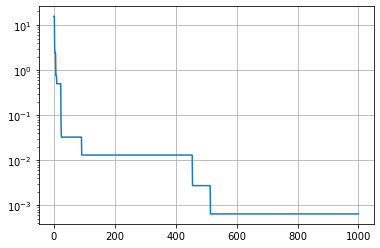

In [63]:
size = 5

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)

##### $\mu = 10$

Algorytm zajął: 0.05531s
Step: 2	 Position: [3.35948, 1.78833]	 Value: 4.49900
Step: 6	 Position: [3.03567, 1.53794]	 Value: 2.61793
Step: 7	 Position: [2.82825, 2.15033]	 Value: 0.92812
Step: 8	 Position: [2.91760, 2.00689]	 Value: 0.23407
Step: 14	 Position: [2.95656, 2.01679]	 Value: 0.05913
Step: 71	 Position: [3.02425, 2.01856]	 Value: 0.03689
Step: 147	 Position: [3.01870, 1.97429]	 Value: 0.01451
Step: 408	 Position: [2.99125, 1.99836]	 Value: 0.00316
Step: 517	 Position: [2.99990, 2.00649]	 Value: 0.00071


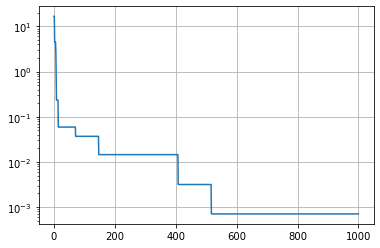

In [64]:
size = 10

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)

##### $\mu =20$

Algorytm zajął: 0.10570s
Step: 2	 Position: [-3.27188, 2.77400]	 Value: 12.78644
Step: 4	 Position: [-3.16958, 3.28993]	 Value: 5.88557
Step: 5	 Position: [-2.88326, 3.41051]	 Value: 3.58031
Step: 6	 Position: [-2.56300, 3.04359]	 Value: 2.01467
Step: 8	 Position: [-2.91927, 3.24909]	 Value: 1.00102
Step: 9	 Position: [-2.83993, 2.98113]	 Value: 0.91000
Step: 14	 Position: [-2.84913, 3.11044]	 Value: 0.08237
Step: 47	 Position: [-2.77290, 3.12361]	 Value: 0.03539
Step: 121	 Position: [-2.80316, 3.14973]	 Value: 0.01389
Step: 156	 Position: [-2.81675, 3.12885]	 Value: 0.00470
Step: 717	 Position: [-2.81417, 3.13599]	 Value: 0.00350
Step: 757	 Position: [-2.80408, 3.13377]	 Value: 0.00028


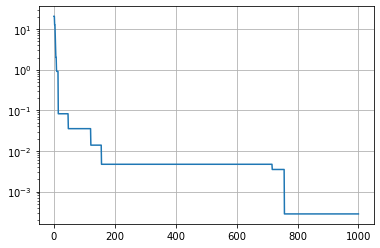

In [65]:
size = 20

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)

##### $\mu =50$

Algorytm zajął: 0.23160s
Step: 2	 Position: [3.22996, 1.56476]	 Value: 2.74137
Step: 8	 Position: [2.76459, 2.05878]	 Value: 1.68550
Step: 10	 Position: [2.91002, 2.25199]	 Value: 1.04163
Step: 12	 Position: [2.88372, 2.05102]	 Value: 0.40905
Step: 26	 Position: [2.94182, 2.05285]	 Value: 0.11011
Step: 55	 Position: [2.98990, 1.96248]	 Value: 0.03481
Step: 87	 Position: [2.98773, 1.99491]	 Value: 0.00724
Step: 298	 Position: [2.99863, 1.99068]	 Value: 0.00180
Step: 781	 Position: [3.00091, 2.00567]	 Value: 0.00068


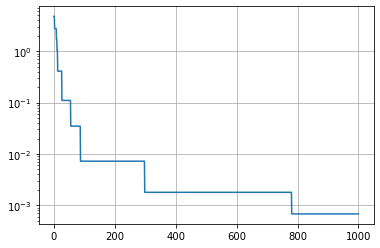

In [66]:
size = 50

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)

#### Ackley function

##### $\mu =5$

Algorytm zajął: 0.07835s
Step: 1	 Position: [-2.00035, 4.93589]	 Value: 10.68936
Step: 5	 Position: [-1.17728, 3.87601]	 Value: 9.66072
Step: 10	 Position: [-0.77939, 3.09459]	 Value: 8.32362
Step: 13	 Position: [-0.78154, 2.95594]	 Value: 7.95430
Step: 16	 Position: [-0.88902, 2.94173]	 Value: 7.42791
Step: 17	 Position: [-1.31897, 1.97700]	 Value: 7.09775
Step: 19	 Position: [-1.81105, 1.13847]	 Value: 6.27475
Step: 20	 Position: [-1.53673, 0.97128]	 Value: 6.24725
Step: 23	 Position: [-1.38731, 0.54978]	 Value: 6.09840
Step: 24	 Position: [-0.30445, 0.27609]	 Value: 3.06832
Step: 28	 Position: [-0.12619, 0.02880]	 Value: 0.75832
Step: 42	 Position: [-0.01332, -0.05706]	 Value: 0.25473
Step: 98	 Position: [0.02045, 0.04805]	 Value: 0.21888
Step: 114	 Position: [0.02291, -0.02363]	 Value: 0.12174
Step: 132	 Position: [-0.00284, 0.01048]	 Value: 0.03385
Step: 305	 Position: [-0.00911, -0.00066]	 Value: 0.02805


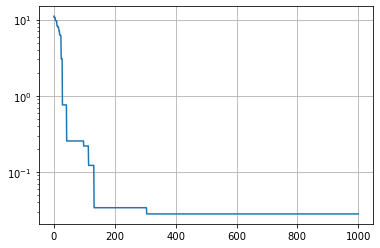

In [67]:
size = 5

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $\mu = 10$

Algorytm zajął: 0.12468s
Step: 1	 Position: [-0.37629, -1.41731]	 Value: 6.01045
Step: 3	 Position: [-1.87753, -0.22980]	 Value: 5.88687
Step: 4	 Position: [-0.01628, -1.27116]	 Value: 4.47034
Step: 5	 Position: [-0.07138, -1.00836]	 Value: 2.79715
Step: 18	 Position: [-0.10346, 0.06022]	 Value: 0.68461
Step: 38	 Position: [-0.01020, 0.02984]	 Value: 0.11549
Step: 264	 Position: [0.02094, -0.02022]	 Value: 0.10477
Step: 429	 Position: [-0.00937, -0.02005]	 Value: 0.07559
Step: 446	 Position: [0.01635, -0.01428]	 Value: 0.07391
Step: 825	 Position: [0.01746, 0.00966]	 Value: 0.06702


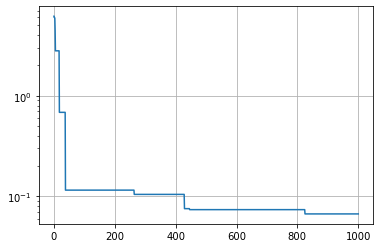

In [68]:
size = 10

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $\mu = 20$

Algorytm zajął: 0.19738s
Step: 3	 Position: [-0.62162, 0.89318]	 Value: 4.54000
Step: 4	 Position: [-0.74507, 0.31781]	 Value: 4.08219
Step: 5	 Position: [0.18159, 0.94976]	 Value: 3.29339
Step: 7	 Position: [0.14924, -0.38931]	 Value: 2.94774
Step: 9	 Position: [-0.25480, -0.21174]	 Value: 2.52415
Step: 11	 Position: [0.07459, 0.03343]	 Value: 0.40066
Step: 16	 Position: [0.04507, -0.02586]	 Value: 0.21752
Step: 33	 Position: [-0.04425, 0.00331]	 Value: 0.17711
Step: 185	 Position: [0.02527, 0.03375]	 Value: 0.16604
Step: 213	 Position: [0.01927, -0.01479]	 Value: 0.08438
Step: 364	 Position: [0.00372, 0.02140]	 Value: 0.07396
Step: 497	 Position: [0.00196, 0.01496]	 Value: 0.04872
Step: 535	 Position: [-0.00365, -0.00390]	 Value: 0.01586
Step: 602	 Position: [0.00086, 0.00430]	 Value: 0.01290


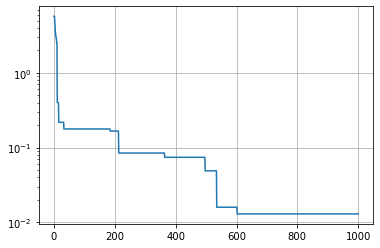

In [69]:
size = 20

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $\mu =50$

Algorytm zajął: 0.42008s
Step: 1	 Position: [-0.17522, -1.03228]	 Value: 3.42445
Step: 5	 Position: [0.08693, -0.95583]	 Value: 2.77712
Step: 8	 Position: [-0.00299, 0.09260]	 Value: 0.47524
Step: 19	 Position: [-0.03789, -0.05878]	 Value: 0.32374
Step: 20	 Position: [0.03128, -0.00379]	 Value: 0.11536
Step: 67	 Position: [0.00563, 0.00231]	 Value: 0.01819


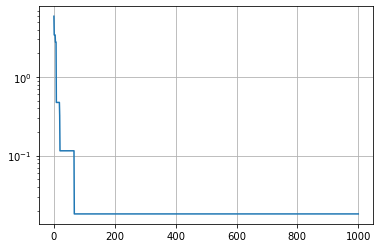

In [70]:
size = 50

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


#### Komentarz
Nie jest zaskoczeniem, że rozmiar populacji wpłynął na czas wykonywania algorytmu. Z eksperymentów nie wynika, aby większy rozmiar populacji w zauważalny sposób poprawiał otrzymywane wyniki. Prawdą jest, że większa ilość osobników ma lepsze zdolności eksploracyjne obszaru, ale poniważ często mamy jakieś informacje o przeszukiwanej funkcji możemy ograniczyć ten obszar. Taka sytuacja wydarzyła się dal dwóch sprawdzanych funkcji, gdzie bezpiecznie mogliśmy ograniczyć interesujący nas obszar do $[-7;7]\times[-7;7]$. W takiej sytuacji nadmierna ilość osobników nie wnosiła nadmiernej korzyści. Lepszym rozwiązaniem byłoby zaczęcie z dużą populacją w celu szybkiego przeszukania przestrzeni, a następnie zmniejszanie ilości osobników, by przyspieszyć działąnie algorytmu i skupienie się na eksploatacji ograniczonych obszarów.

### Ilość iteracji - $t$

In [71]:
restrictions = ((-7,7),(-7,7))
size = 20
mutation_strength = 0.3
crossover_probability =  0.1

#### Himmelblau function

##### $t = 50$

Algorytm zajął: 0.00575s
Step: 31	 Position: [-2.76531, 3.12510]	 Value: 0.05197


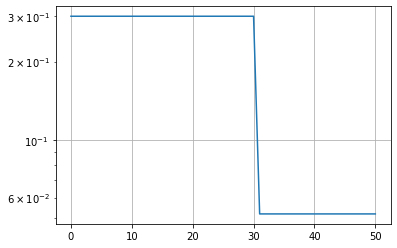

In [72]:
iterations = 50

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


##### $t = 100$

Algorytm zajął: 0.01084s
Step: 5	 Position: [-2.61438, 2.84639]	 Value: 4.02627
Step: 6	 Position: [-2.87865, 2.85724]	 Value: 2.96138
Step: 7	 Position: [-2.72008, 3.18229]	 Value: 0.34103
Step: 50	 Position: [-2.77161, 3.16615]	 Value: 0.08705


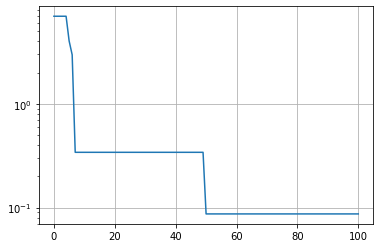

In [73]:
iterations = 100

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $t = 1000$

Algorytm zajął: 0.10042s
Step: 3	 Position: [3.52444, -1.19925]	 Value: 4.20035
Step: 4	 Position: [3.53306, -1.47283]	 Value: 1.68417
Step: 7	 Position: [3.54970, -1.71943]	 Value: 0.25807
Step: 11	 Position: [3.62195, -1.89404]	 Value: 0.09420
Step: 12	 Position: [3.55855, -1.79820]	 Value: 0.06145
Step: 15	 Position: [3.57088, -1.85393]	 Value: 0.01062
Step: 489	 Position: [3.59740, -1.85204]	 Value: 0.00872
Step: 735	 Position: [3.58590, -1.86768]	 Value: 0.00557
Step: 737	 Position: [3.58839, -1.86025]	 Value: 0.00266
Step: 853	 Position: [3.58787, -1.85544]	 Value: 0.00123


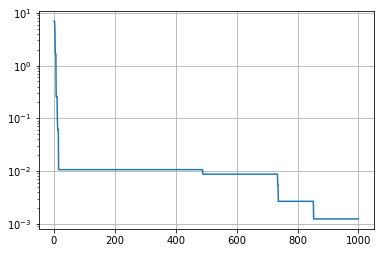

In [74]:
iterations = 1000

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


##### $t = 10000$

Algorytm zajął: 0.95375s
Step: 2	 Position: [3.34337, 1.88706]	 Value: 4.27426
Step: 4	 Position: [2.89675, 2.11516]	 Value: 0.38111
Step: 8	 Position: [3.00840, 1.91638]	 Value: 0.10292
Step: 10	 Position: [2.97588, 2.06086]	 Value: 0.05668
Step: 12	 Position: [2.96285, 2.03672]	 Value: 0.04650
Step: 95	 Position: [3.02629, 1.99130]	 Value: 0.02250
Step: 111	 Position: [3.01233, 2.02189]	 Value: 0.01930
Step: 274	 Position: [3.01067, 2.00904]	 Value: 0.00755
Step: 927	 Position: [2.99042, 1.99888]	 Value: 0.00362
Step: 1533	 Position: [3.00606, 1.98527]	 Value: 0.00324
Step: 1780	 Position: [2.99890, 1.98890]	 Value: 0.00237
Step: 2048	 Position: [3.00173, 1.99022]	 Value: 0.00139
Step: 2668	 Position: [3.00508, 1.99606]	 Value: 0.00082
Step: 6823	 Position: [3.00092, 1.99280]	 Value: 0.00078
Step: 7209	 Position: [3.00453, 1.99759]	 Value: 0.00064
Step: 8812	 Position: [2.99777, 2.00051]	 Value: 0.00016


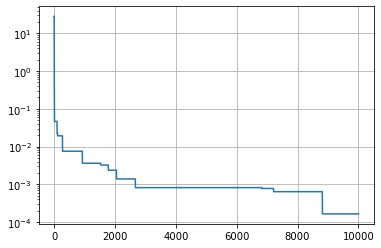

In [75]:
iterations = 10000

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


#### Ackley function

##### $t = 50$

Algorytm zajął: 0.01078s
Step: 1	 Position: [1.92185, -1.21240]	 Value: 6.46787
Step: 2	 Position: [0.99502, -0.78144]	 Value: 4.17665
Step: 3	 Position: [0.20791, -0.98508]	 Value: 3.49764
Step: 5	 Position: [-0.88615, -0.07387]	 Value: 2.80085
Step: 9	 Position: [-0.89115, -0.04552]	 Value: 2.70904
Step: 11	 Position: [-0.18340, 0.03564]	 Value: 1.24470
Step: 12	 Position: [-0.13760, -0.08887]	 Value: 1.06239
Step: 20	 Position: [-0.10382, -0.02994]	 Value: 0.59002
Step: 23	 Position: [0.01377, -0.10185]	 Value: 0.54927
Step: 26	 Position: [0.04188, -0.07491]	 Value: 0.42906
Step: 27	 Position: [0.07579, -0.01584]	 Value: 0.37124
Step: 37	 Position: [0.02672, -0.01297]	 Value: 0.10734
Step: 39	 Position: [-0.02554, 0.00372]	 Value: 0.09063


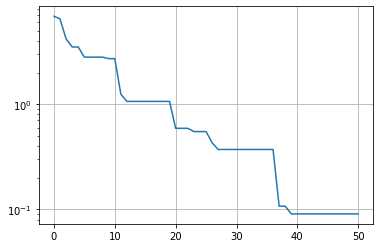

In [76]:
iterations = 50

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


##### $t = 100$

Algorytm zajął: 0.02535s
Step: 1	 Position: [1.22817, -2.22932]	 Value: 7.62166
Step: 2	 Position: [1.08341, -2.99457]	 Value: 7.42919
Step: 3	 Position: [1.07859, -1.93942]	 Value: 5.63489
Step: 7	 Position: [0.90343, -1.04709]	 Value: 3.83840
Step: 10	 Position: [0.06398, -0.49022]	 Value: 3.10699
Step: 12	 Position: [0.16628, 0.22451]	 Value: 2.10105
Step: 13	 Position: [0.04587, 0.16634]	 Value: 1.12478
Step: 14	 Position: [-0.05131, -0.12559]	 Value: 0.81306
Step: 27	 Position: [-0.07155, 0.03587]	 Value: 0.38937
Step: 50	 Position: [0.06998, -0.01547]	 Value: 0.33408
Step: 53	 Position: [-0.00761, 0.01805]	 Value: 0.06560


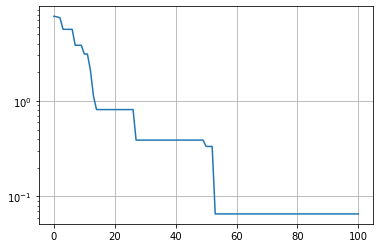

In [77]:
iterations = 100

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)



##### $t = 1000$

Algorytm zajął: 0.18677s
Step: 3	 Position: [0.16757, 1.08827]	 Value: 3.64295
Step: 4	 Position: [-0.06427, 0.85460]	 Value: 2.85162
Step: 5	 Position: [-0.00265, 0.39480]	 Value: 2.69338
Step: 7	 Position: [-0.29058, -0.17698]	 Value: 2.55781
Step: 8	 Position: [-0.05544, 0.17772]	 Value: 1.24560
Step: 12	 Position: [-0.05277, -0.05797]	 Value: 0.37889
Step: 54	 Position: [0.06808, 0.01308]	 Value: 0.31925
Step: 87	 Position: [-0.04459, 0.03299]	 Value: 0.23715
Step: 124	 Position: [-0.01516, 0.00092]	 Value: 0.04907
Step: 404	 Position: [-0.00525, 0.00731]	 Value: 0.02761


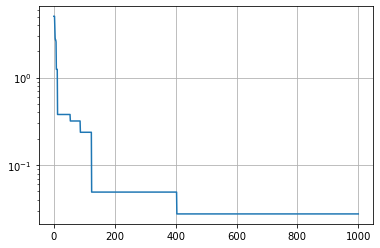

In [78]:
iterations = 1000

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


##### $t = 10000$

Algorytm zajął: 1.91921s
Step: 2	 Position: [-1.00933, -0.94177]	 Value: 3.63779
Step: 8	 Position: [-0.19168, 0.94118]	 Value: 3.35185
Step: 9	 Position: [0.10961, 0.83670]	 Value: 3.06190
Step: 11	 Position: [0.27888, -0.28536]	 Value: 2.99722
Step: 12	 Position: [0.33041, 0.23103]	 Value: 2.99357
Step: 13	 Position: [0.22582, 0.00097]	 Value: 1.56861
Step: 15	 Position: [-0.01649, 0.09927]	 Value: 0.53346
Step: 22	 Position: [-0.04381, -0.04077]	 Value: 0.26242
Step: 39	 Position: [0.00052, 0.00205]	 Value: 0.00609


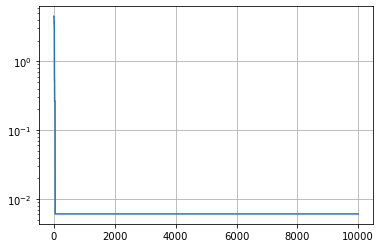

In [79]:
iterations = 10000

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


#### Komentarz
Ponownie, większa liczba obliczeń wydłuża czas wykonania całego algorytmu. Chociaż w przeciwieństwie do większej liczby populacji, większa ilość iteracji może faktycznie przynieść pozytywne rezultaty jeśli chodzi o minimalizacje funkcji. Jest to algorytm heurystyczny, więc nie ma gwarancji, że zawsze przykładowo, po $10^4$ iteracji osiągnie się lepszy wynik niż po $10^3$ iteracji. Natomiast rośnie szansa na wyprodukowanie lepszego osbnika. Zbyt mała liczba iteracji w oczywisty sposób utrudnia znlezienia jakiegokolwiek senoswnego wyniku, nie ma dość czasu, aby dostatecznie przeszuakć oczekiwaną przestrzeń. 

### Siła mutacji - $\sigma$

In [80]:
restrictions = ((-7,7),(-7,7))
iterations = 1000
size = 20
crossover_probability =  0.1

#### Himmelblau function

##### $\sigma=0.5$

Algorytm zajął: 0.16363s
Step: 14	 Position: [3.66200, -1.95126]	 Value: 0.43102
Step: 15	 Position: [3.59446, -1.71911]	 Value: 0.24311
Step: 19	 Position: [3.59408, -1.90441]	 Value: 0.04895
Step: 88	 Position: [3.57420, -1.86636]	 Value: 0.01167
Step: 576	 Position: [3.59664, -1.86636]	 Value: 0.01121
Step: 625	 Position: [3.58744, -1.86897]	 Value: 0.00648


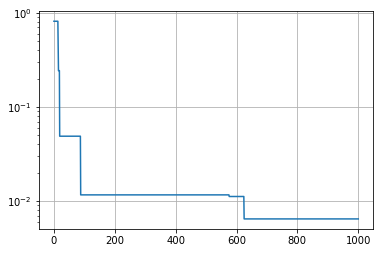

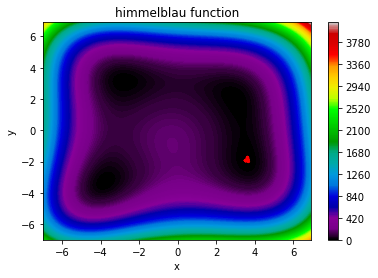

In [81]:
mutation_strength = 0.5

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)

##### $\sigma=0.3$

Algorytm zajął: 0.13661s
Step: 3	 Position: [3.57103, -0.36377]	 Value: 12.79569
Step: 4	 Position: [3.36739, -1.48600]	 Value: 3.34383
Step: 6	 Position: [3.64180, -1.80887]	 Value: 0.21337
Step: 7	 Position: [3.57683, -1.88709]	 Value: 0.02775
Step: 40	 Position: [3.57091, -1.84040]	 Value: 0.00969
Step: 768	 Position: [3.58043, -1.82705]	 Value: 0.00669


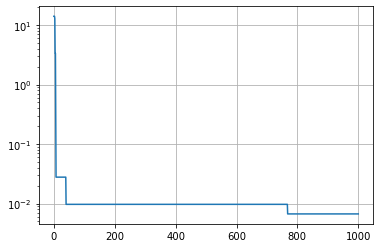

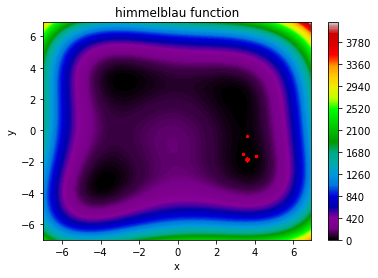

In [82]:
mutation_strength = 0.3

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)



##### $\sigma=0.1$

Algorytm zajął: 0.14548s
Step: 3	 Position: [3.64968, -1.43669]	 Value: 2.43487
Step: 4	 Position: [3.71094, -1.75419]	 Value: 1.07894
Step: 7	 Position: [3.58815, -1.67639]	 Value: 0.40124
Step: 8	 Position: [3.59133, -1.79359]	 Value: 0.04758
Step: 10	 Position: [3.58777, -1.86961]	 Value: 0.00693
Step: 23	 Position: [3.58417, -1.82710]	 Value: 0.00638
Step: 74	 Position: [3.59116, -1.85447]	 Value: 0.00267
Step: 96	 Position: [3.58286, -1.85597]	 Value: 0.00112
Step: 158	 Position: [3.58792, -1.84327]	 Value: 0.00110
Step: 579	 Position: [3.58571, -1.84465]	 Value: 0.00029


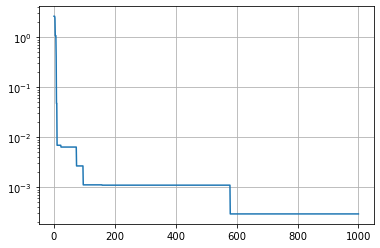

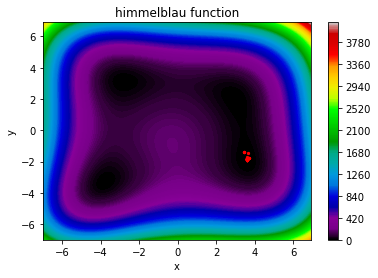

In [83]:
mutation_strength = 0.1

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


##### $\sigma=0.01$

Algorytm zajął: 0.11370s
Step: 2	 Position: [3.13321, -0.78096]	 Value: 14.46429
Step: 3	 Position: [3.13707, -0.77536]	 Value: 14.38000
Step: 4	 Position: [3.12237, -0.97551]	 Value: 13.51814
Step: 6	 Position: [3.11900, -1.00491]	 Value: 13.42705
Step: 7	 Position: [3.23066, -0.80235]	 Value: 11.63301
Step: 9	 Position: [3.24740, -0.80509]	 Value: 11.22366
Step: 10	 Position: [3.27997, -0.81556]	 Value: 10.45032
Step: 12	 Position: [3.27868, -0.82237]	 Value: 10.42266
Step: 13	 Position: [3.29026, -0.81992]	 Value: 10.21452
Step: 16	 Position: [3.31520, -0.82554]	 Value: 9.71693
Step: 17	 Position: [3.32295, -0.81382]	 Value: 9.68442
Step: 18	 Position: [3.33264, -0.81982]	 Value: 9.48036
Step: 19	 Position: [3.36759, -0.81957]	 Value: 8.99518
Step: 20	 Position: [3.37973, -0.83241]	 Value: 8.73736
Step: 21	 Position: [3.41685, -0.83812]	 Value: 8.32510
Step: 22	 Position: [3.43789, -0.85293]	 Value: 8.03625
Step: 26	 Position: [3.44361, -0.87405]	 Value: 7.79786
Step: 28	 Position: 

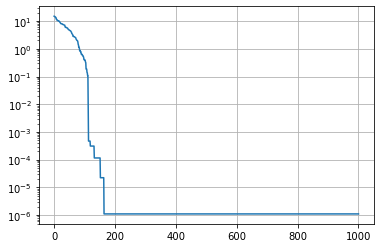

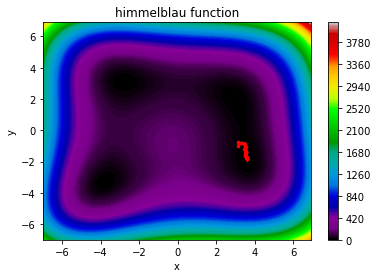

In [84]:
mutation_strength = 0.01

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


#### Ackley function

##### $\sigma=0.5$

Algorytm zajął: 0.20035s
Step: 4	 Position: [0.72671, 0.10491]	 Value: 3.31049
Step: 6	 Position: [0.06833, 0.94817]	 Value: 2.70386
Step: 9	 Position: [0.16144, -0.20094]	 Value: 1.91869
Step: 10	 Position: [-0.03410, -0.20771]	 Value: 1.44622
Step: 12	 Position: [-0.16455, 0.03839]	 Value: 1.09198
Step: 20	 Position: [0.01637, -0.02016]	 Value: 0.09134


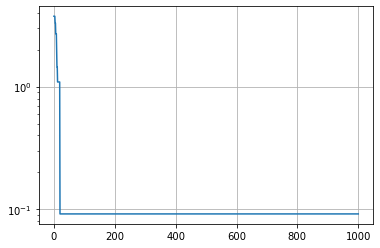

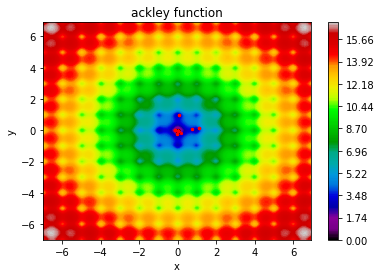

In [85]:
mutation_strength = 0.5

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)



##### $\sigma=0.3$

Algorytm zajął: 0.22593s
Step: 1	 Position: [-2.45828, -0.05657]	 Value: 7.60677
Step: 2	 Position: [0.00594, -0.70515]	 Value: 3.18239
Step: 8	 Position: [-0.09654, -0.23078]	 Value: 1.81181
Step: 13	 Position: [-0.16404, 0.13695]	 Value: 1.52195
Step: 16	 Position: [0.00529, 0.00645]	 Value: 0.02544


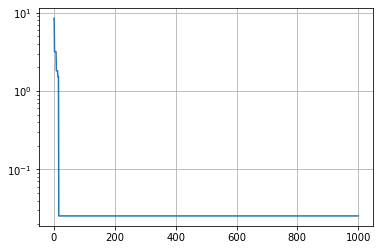

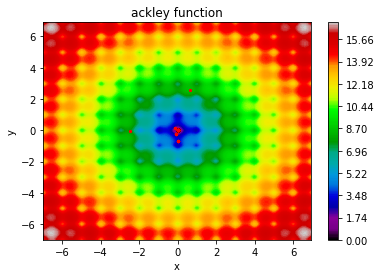

In [86]:
mutation_strength = 0.3

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)


##### $\sigma=0.1$

Algorytm zajął: 0.27975s
Step: 1	 Position: [0.60862, 0.00900]	 Value: 3.25027
Step: 3	 Position: [0.48755, 0.12753]	 Value: 3.23386
Step: 4	 Position: [0.49363, -0.01891]	 Value: 3.07093
Step: 5	 Position: [0.42829, -0.07802]	 Value: 2.92141
Step: 6	 Position: [0.29810, -0.07056]	 Value: 2.21254
Step: 7	 Position: [0.13739, -0.12738]	 Value: 1.28069
Step: 8	 Position: [0.09286, 0.10715]	 Value: 0.87149
Step: 10	 Position: [-0.02892, -0.06112]	 Value: 0.30904
Step: 12	 Position: [0.04475, -0.03740]	 Value: 0.25353
Step: 15	 Position: [0.01678, -0.03631]	 Value: 0.15526
Step: 17	 Position: [0.00934, -0.01515]	 Value: 0.05874
Step: 42	 Position: [0.01223, 0.01122]	 Value: 0.05426
Step: 44	 Position: [-0.00567, -0.00520]	 Value: 0.02332
Step: 198	 Position: [0.00194, 0.00654]	 Value: 0.02053
Step: 390	 Position: [-0.00467, 0.00067]	 Value: 0.01392
Step: 428	 Position: [0.00201, 0.00363]	 Value: 0.01220
Step: 760	 Position: [-0.00223, -0.00321]	 Value: 0.01145
Step: 784	 Position: [-0.0009

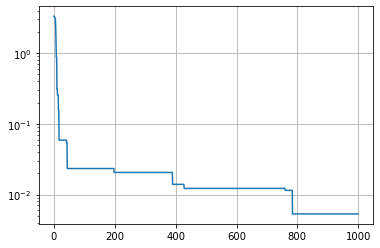

In [87]:
mutation_strength = 0.1

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


##### $\sigma=0.01$

Algorytm zajął: 0.19421s
Step: 3	 Position: [-0.02696, 0.92360]	 Value: 2.61757
Step: 5	 Position: [-0.01687, 0.91879]	 Value: 2.61223
Step: 7	 Position: [0.00229, 0.92789]	 Value: 2.59343
Step: 8	 Position: [0.00187, 0.95173]	 Value: 2.58003
Step: 68	 Position: [-0.00053, 0.95305]	 Value: 2.57995
Step: 84	 Position: [0.00051, 0.95194]	 Value: 2.57994
Step: 278	 Position: [-0.00026, 0.95218]	 Value: 2.57993


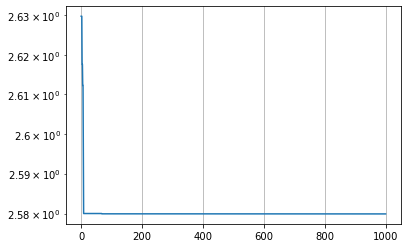

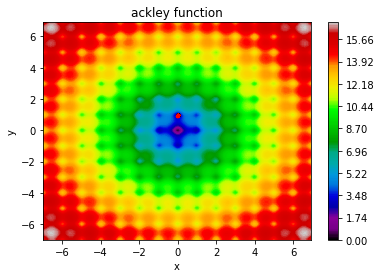

In [88]:
mutation_strength = 0.01

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)


#### Komentarz
Duży, względem całego przedziału, współczynnik mutacji pozwala na szybkoe przeszukanie funkcji i znalezienie otoczenia minimum, natomiast samo dokładne zbadanie tego obszru staje się trudnością, ponieważ mimo losowej mutacji punkty często przeskakują przez minimum, nieznajdując lepszego rozwiązania. Dlatego na przykładzie funkcji Himmelblau najlepsze wyniki osiągnięto dla mniejszej siły mutacji. Niez naczy to jednak, że takie podejście jest skuteczne w każdej sytuacji, zbyt mała siła mutacji, może powodować utykanie w minimum funkcji. Najskuteczniejszym rozwiązaniem byłoby dynamiczna zmiana siły mutacji dla osobników, ale spowodowało by to znaczne skomplikowanie algorytmu.

### Prawdopodobieństwo krzyżowania $p_c$

In [89]:
restrictions = ((-7,7),(-7,7))
iterations = 1000
size = 20
mutation_strength = 0.3

#### Himmelblau function

##### $p_c=0.5$

Algorytm zajął: 0.12217s
Step: 1	 Position: [-3.94865, -3.34767]	 Value: 1.61470
Step: 5	 Position: [3.10809, 1.94104]	 Value: 0.37698
Step: 6	 Position: [2.90253, 2.06759]	 Value: 0.28925
Step: 9	 Position: [3.06362, 1.95531]	 Value: 0.12915
Step: 12	 Position: [2.98237, 2.05115]	 Value: 0.03889
Step: 25	 Position: [2.99456, 2.00978]	 Value: 0.00166
Step: 524	 Position: [2.99782, 1.99850]	 Value: 0.00028
Step: 878	 Position: [2.99915, 1.99966]	 Value: 0.00003


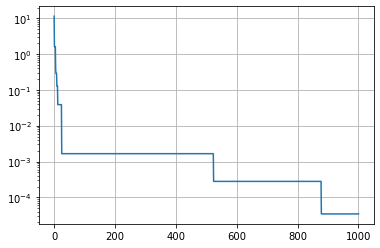

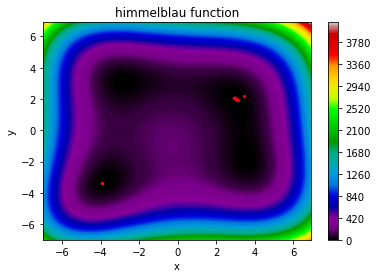

In [90]:
crossover_probability = 0.5

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


##### $p_c=0.3$

Algorytm zajął: 0.11010s
Step: 4	 Position: [3.56845, -2.32450]	 Value: 4.23672
Step: 5	 Position: [3.78656, -1.84490]	 Value: 2.26561
Step: 7	 Position: [3.47764, -1.94742]	 Value: 0.80132
Step: 10	 Position: [3.50364, -1.75749]	 Value: 0.39844
Step: 14	 Position: [3.61593, -1.75701]	 Value: 0.18930
Step: 28	 Position: [3.59851, -1.77481]	 Value: 0.09372
Step: 44	 Position: [3.60774, -1.90793]	 Value: 0.07312
Step: 66	 Position: [3.60949, -1.86105]	 Value: 0.03335
Step: 94	 Position: [3.57243, -1.88568]	 Value: 0.03168
Step: 97	 Position: [3.57139, -1.86334]	 Value: 0.01366
Step: 127	 Position: [3.59712, -1.83279]	 Value: 0.01325
Step: 155	 Position: [3.58991, -1.84046]	 Value: 0.00273
Step: 205	 Position: [3.58399, -1.84704]	 Value: 0.00002


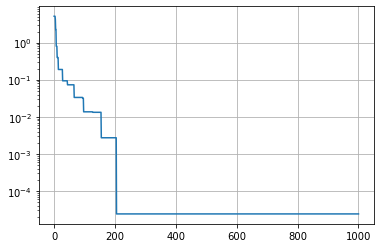

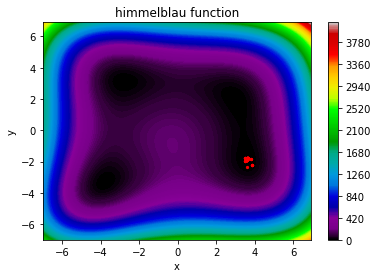

In [91]:
crossover_probability = 0.3

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


##### $p_c=0.1$

Algorytm zajął: 0.11718s
Step: 1	 Position: [2.98371, 1.64018]	 Value: 1.96769
Step: 6	 Position: [3.08543, 1.73293]	 Value: 0.89478
Step: 16	 Position: [3.06893, 1.73604]	 Value: 0.86514
Step: 18	 Position: [3.03837, 1.82971]	 Value: 0.38053
Step: 27	 Position: [3.00949, 1.96913]	 Value: 0.01346
Step: 298	 Position: [2.98784, 2.02586]	 Value: 0.01066


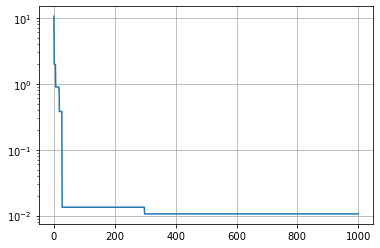

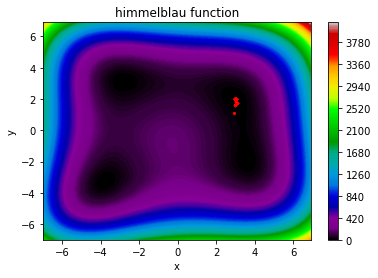

In [92]:
crossover_probability = 0.1

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


##### $p_c=0.01$

Algorytm zajął: 0.11575s
Step: 1	 Position: [-3.99131, -3.36263]	 Value: 2.55830
Step: 3	 Position: [-3.79444, -3.39196]	 Value: 0.50553
Step: 72	 Position: [-3.84565, -3.29910]	 Value: 0.24148
Step: 113	 Position: [-3.72451, -3.26620]	 Value: 0.15862
Step: 152	 Position: [-3.72769, -3.25631]	 Value: 0.14546
Step: 299	 Position: [-3.78798, -3.28465]	 Value: 0.00412


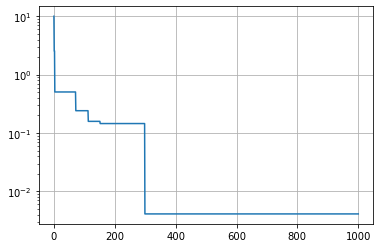

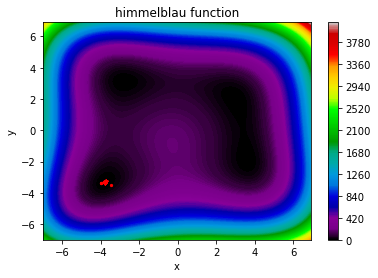

In [93]:
crossover_probability = 0.01

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


#### Ackley function

##### $p_c=0.5$

Algorytm zajął: 0.21159s
Step: 1	 Position: [0.08251, -0.86553]	 Value: 2.88071
Step: 5	 Position: [0.15532, 0.19236]	 Value: 1.82557
Step: 8	 Position: [0.06157, -0.05608]	 Value: 0.41205
Step: 13	 Position: [-0.03105, -0.07267]	 Value: 0.38239
Step: 18	 Position: [0.03182, 0.02057]	 Value: 0.14502
Step: 69	 Position: [0.01081, 0.01762]	 Value: 0.06980
Step: 153	 Position: [-0.00287, 0.00402]	 Value: 0.01462


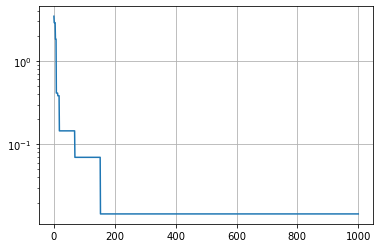

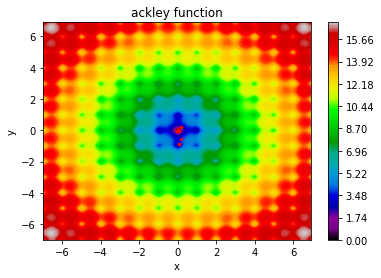

In [94]:
crossover_probability = 0.5

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

##### $p_c=0.3$

Algorytm zajął: 0.21872s
Step: 1	 Position: [0.19329, -0.78106]	 Value: 3.55764
Step: 2	 Position: [0.01839, -0.44164]	 Value: 2.89988
Step: 3	 Position: [0.17399, -0.32503]	 Value: 2.73157
Step: 4	 Position: [-0.16268, -0.02785]	 Value: 1.05609
Step: 9	 Position: [0.00905, -0.12130]	 Value: 0.69415
Step: 11	 Position: [0.01593, 0.03527]	 Value: 0.14889
Step: 47	 Position: [0.03299, 0.01095]	 Value: 0.13020
Step: 118	 Position: [0.01278, 0.00516]	 Value: 0.04404
Step: 280	 Position: [0.00445, 0.00785]	 Value: 0.02768
Step: 739	 Position: [-0.00097, 0.00739]	 Value: 0.02256


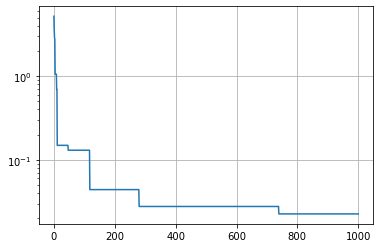

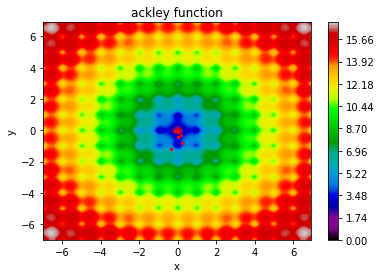

In [95]:
crossover_probability = 0.3

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

##### $p_c=0.1$

Algorytm zajął: 0.22719s
Step: 1	 Position: [2.07536, 1.82095]	 Value: 7.24747
Step: 2	 Position: [-0.10144, -1.23046]	 Value: 4.33354
Step: 3	 Position: [0.85927, 0.24652]	 Value: 3.70541
Step: 4	 Position: [-0.07096, 0.01772]	 Value: 0.34348
Step: 26	 Position: [-0.02414, 0.00043]	 Value: 0.08373
Step: 32	 Position: [-0.00140, -0.01754]	 Value: 0.05798
Step: 518	 Position: [-0.01132, 0.00994]	 Value: 0.04864
Step: 613	 Position: [-0.00370, 0.00707]	 Value: 0.02425


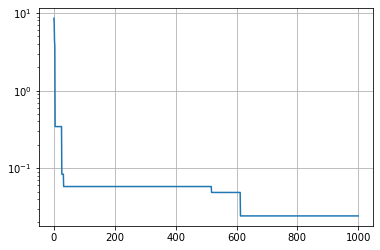

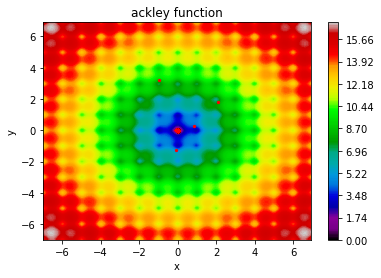

In [96]:
crossover_probability = 0.1

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

##### $p_c=0.01$

Algorytm zajął: 0.24820s
Step: 38	 Position: [-0.17625, 0.04239]	 Value: 1.19889
Step: 42	 Position: [-0.16969, 0.04007]	 Value: 1.13866
Step: 43	 Position: [0.11117, -0.01248]	 Value: 0.61797
Step: 44	 Position: [0.08812, -0.03483]	 Value: 0.49178
Step: 139	 Position: [-0.01019, 0.03900]	 Value: 0.15670
Step: 372	 Position: [0.00203, -0.02166]	 Value: 0.07409
Step: 837	 Position: [-0.01333, -0.01017]	 Value: 0.05490


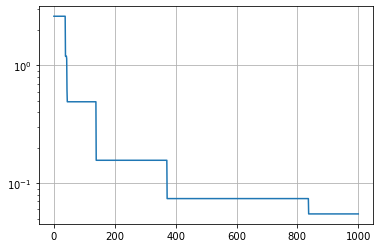

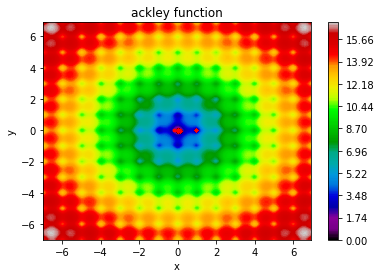

In [97]:
crossover_probability = 0.01

population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

#### Komentarz
Chociaż krzyżowanie nie jest najważnieszją częscią algorytmu ewolucyjnego, może w poprawić jego działanie. Nie stwierdzono znacznego wydłużenia czasu działania algorytmu przez większą ilość krzyżowań między osobnikami. Z wykresów wynika, że krzyżowanie zwiększa częstotliwość drobnych popraw najlepszego osobnika, a nie odkrywanie zupełnie nowych minimów. Zmiana częstotliwości krzyżowania nie wprowadza znaczych zmian do osiąganych wyników.

## Wnioski
Algorytm ewolucyjny jako algorytm heurystyczny, nigdy nie może zagwarantować znalezienia ekstremum globalnego funkcji nie ważne jakie parametry zostaną ustawione. Natomiast dostrajając kolejne parametry możemy zwiększać to prawdopodobnieństwo i optymalizować działanie całego algorytmu. Rozmiar populacji pozwala na lepsze poznawanie przeszukiwanej przestrzeni, natomiast nie zawsze poprawia działanie przy wielu iteracjach, lepsze wydaje się dynamiczne zmniejszanie populacji po pewnej liczbie iteracji, jak przestrzeń zostanie dostatecznie przeszukana. Liczba iteracji oczywiście wydłuża czas, ale na pewno zwiększa szansę na znalezienie lepszego roziwiązania od aktualnego. Siła mutacji, pozwala w skuteczny sposób przeszukiać obszary w otoczenu minimum, jendak zbyt duży współczik może mieć problem z zagłębieiem się do minimum i jedynie krążyć dookoła. Zbyt słaba mutacja może powodować utykanie algorytmu w minimach lokalnych ograniczając możliwości eksploracji przestrzeni. Zmiana prawdopodobieństwa krzyżowania miała najmniejszy wpływ na działanie i skuteczność algorytmu. Dzięki niej częściej pojawiają się nieduże poprawy do najlepszego osobnika, a nie odkrywanie zupełnie nowych rozwiązań. 